<a href="https://colab.research.google.com/github/luispc1989/PML_Final_Project/blob/main/pml_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌱 **CropSuit: A Crop Recommendation Tool Based on Soil Features Using Machine Learning**

Choosing the right crop for a given soil profile is a fundamental decision in sustainable agriculture. Farmers often rely on intuition or past experience to guide their decisions, but this trial-and-error approach can lead to suboptimal yields and inefficient use of land. A data-driven decision support system can significantly improve productivity, particularly for smallholder farmers with limited access to agronomic expertise.

This project introduces **CropSuit**, a machine learning–based recommendation tool that suggests the most suitable crop(s) for a given field based on four essential soil properties: **nitrogen (N)**, **phosphorous (P)**, **potassium (K)**, and **pH**. The objective is to build a robust **multi-class classification system** capable of predicting the optimal crop from a set of **22 distinct crop classes**.

The tool was trained using a clean and balanced dataset (`soil_measures.csv`) sourced from Kaggle, consisting of **2200 samples**. Each sample includes numerical soil measurements and a labeled "ideal" crop.

Key challenges addressed in the development of **CropSuit** include:

- 🌾 **Multi-class classification** across 22 crops with overlapping soil profiles;
- 🧪 **Low feature dimensionality**, using only four input variables;
- ⚖️ **Ambiguity and uncertainty**, as many soils are suitable for multiple crops;
- 🔍 The need for **interpretability** to foster user trust and facilitate agronomic decision-making.

By comparing a range of classification models, applying rigorous evaluation techniques (including confidence intervals and cross-validation), and deploying a user-friendly prediction interface, **CropSuit** demonstrates the practical application of machine learning for data-driven agriculture.

**Note:** The report is included on this notebook.


# 1. Importing Libraries

This section imports all required libraries to support the end-to-end machine learning workflow.

Core packages include tools for data handling (`pandas`, `numpy`), visualization (`matplotlib`, `seaborn`), machine learning (`scikit-learn`), statistical analysis (`scipy`), and model persistence (`joblib`). Additionally, the `kagglehub` library is used to automate dataset retrieval from Kaggle.

We also define global plotting parameters using Seaborn and Matplotlib to ensure consistent aesthetics throughout the notebook.



In [1]:
# Data manipulation and I/O
import pandas as pd
import numpy as np
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn core: preprocessing, pipelines, models, evaluation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.inspection import permutation_importance

# Statistical tools
from scipy.stats import zscore

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Model persistence
import joblib

# Dataset download (Kaggle)
import kagglehub as kh

# Aesthetic settings for plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 2. Load and Clean Dataset

This section handles the acquisition and validation of the dataset used in this project.

- The dataset is automatically downloaded from Kaggle using `kagglehub`.
- The file is loaded into a pandas DataFrame, and column names are standardized to lowercase to ensure consistency.
- Initial inspection steps confirm the data structure, verify the presence of all expected columns (`n`, `p`, `k`, `ph`, `crop`), and check for any missing values.
- Finally, a simple outlier detection step is performed using the Z-score method, flagging values that deviate more than three standard deviations from the mean in any numeric feature.

These steps ensure that the dataset is clean and suitable for modeling, with no missing values and a consistent format.


In [2]:

# Download dataset from Kaggle using kagglehub
path = kh.dataset_download("mohamedmostafa259/soil-measures")
print("✅ Dataset downloaded to:", path)

# Construct full file path for the CSV file
file_path = os.path.join(path, "soil_measures.csv")

# Load the dataset into a pandas DataFrame
crops = pd.read_csv(file_path)
print("✅ Dataset loaded successfully!")

try:
    crops = pd.read_csv(file_path)
except FileNotFoundError:
    raise FileNotFoundError("❌ Could not load CSV. Check the dataset path or download process.")

# Standardize column names
crops.columns = crops.columns.str.strip().str.lower()
print("✅ Column names cleaned:", crops.columns.tolist())

# Preview first few rows
print("\n🔎 Preview of the dataset:")
display(crops.head())

#  Check structure and data types
print("\nℹ️ Dataset structure:")
print(crops.info())

# Check for missing values
print("\n🧼 Missing values per column:")
print(crops.isnull().sum())

# Validate expected columns exist
expected_cols = ['n', 'p', 'k', 'ph', 'crop']
missing_cols = [col for col in expected_cols if col not in crops.columns]
if missing_cols:
    raise ValueError(f"❌ Missing expected columns: {missing_cols}")
else:
    print("✅ All expected columns are present.")

# Detect outliers in numeric features using Z-score method
numeric_features = ['n', 'p', 'k', 'ph']
z_scores = np.abs(zscore(crops[numeric_features]))
outliers = (z_scores > 3).sum(axis=0)

print("\n⚠️ Potential Outliers per Feature (Z-score > 3):")
for feature, count in zip(numeric_features, outliers):
    print(f"{feature:<10}: {count} outliers")

✅ Dataset downloaded to: /kaggle/input/soil-measures
✅ Dataset loaded successfully!
✅ Column names cleaned: ['n', 'p', 'k', 'ph', 'crop']

🔎 Preview of the dataset:


,n,p,k,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice



ℹ️ Dataset structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   n       2200 non-null   int64  
 1   p       2200 non-null   int64  
 2   k       2200 non-null   int64  
 3   ph      2200 non-null   float64
 4   crop    2200 non-null   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 86.1+ KB
None

🧼 Missing values per column:
n       0
p       0
k       0
ph      0
crop    0
dtype: int64
✅ All expected columns are present.

⚠️ Potential Outliers per Feature (Z-score > 3):
n         : 0 outliers
p         : 0 outliers
k         : 94 outliers
ph        : 30 outliers


## Interpretation (part 2)

The dataset was successfully loaded and consists of 2,200 observations with 5 columns: four numerical soil features (`n`, `p`, `k`, `ph`) and one categorical target variable (`crop`). All columns are present and contain no missing values, confirming that the dataset is complete and ready for modeling without the need for imputation.

An outlier detection step using the Z-score method revealed that:
- `N` (Nitrogen) and `P` (Phosphorous) features contain no significant outliers.
- `K` (Potassium) has 94 observations flagged as potential outliers.
- `pH` has 3 observations above the standard threshold.

These outliers may reflect natural variation in soil properties and are retained in the dataset for now, as no clear justification exists to exclude them without domain-specific thresholds. Further investigation during model evaluation may help assess their impact on performance.


# 3. Exploratory Data Analysis (EDA)

In this section, we perform an exploratory analysis to understand the distribution and characteristics of the soil features and the target variable (`crop`).

- We begin by examining the frequency of each crop class to assess class balance.
- Descriptive statistics are computed for the numerical features: nitrogen (`n`), phosphorous (`p`), potassium (`k`), and soil pH (`ph`).
- Histograms are used to visualize the distribution of each feature across all samples.
- Boxplots provide insight into how each soil feature varies across different crop types.
- Finally, a correlation heatmap is used to examine potential linear relationships between the input features.

These visual and statistical summaries help uncover patterns, potential anomalies, and relationships that may influence model performance later on.



In [3]:

# Crop type distribution
print("\n🌾 Crop type distribution (value counts):")
crop_counts = crops['crop'].value_counts()
print(crop_counts)

if crop_counts.nunique() == 1:
    print("✅ All crop classes are perfectly balanced.")


🌾 Crop type distribution (value counts):
crop
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
pomegranate    100
banana         100
mango          100
grapes         100
watermelon     100
muskmelon      100
apple          100
orange         100
papaya         100
coconut        100
cotton         100
jute           100
coffee         100
Name: count, dtype: int64
✅ All crop classes are perfectly balanced.


In [4]:
# Descriptive statistics for numeric soil features
print("\n📈 Descriptive statistics for soil features:")
numeric_features = ['n', 'p', 'k', 'ph']
display(crops[numeric_features].describe().round(2))


📈 Descriptive statistics for soil features:


,n,p,k,ph
count,2200.00,2200.00,2200.00,2200.00
mean,50.55,53.36,48.15,6.47
std,36.92,32.99,50.65,0.77
min,0.00,5.00,5.00,3.50
25%,21.00,28.00,20.00,5.97
50%,37.00,51.00,32.00,6.43
75%,84.25,68.00,49.00,6.92
max,140.00,145.00,205.00,9.94


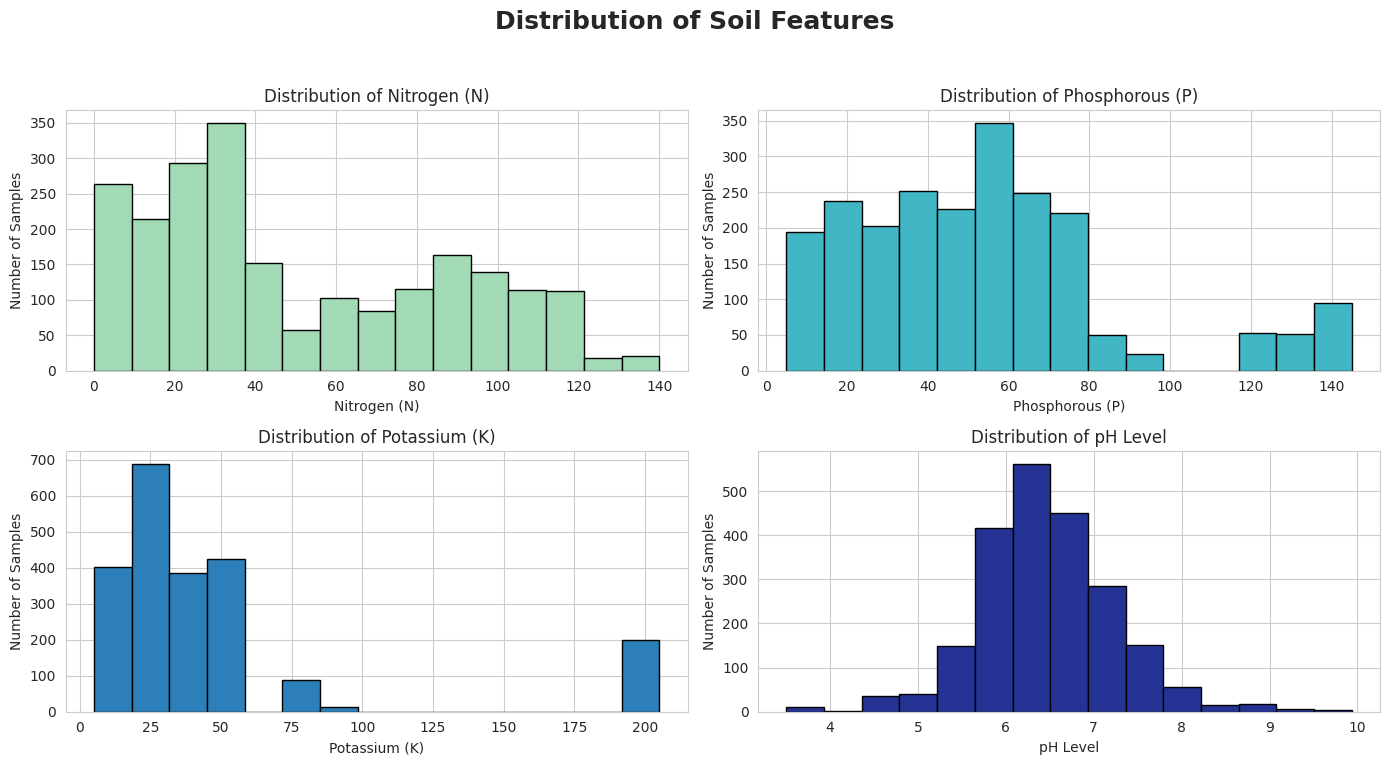

In [5]:
# Histograms of numeric features
titles = ['Nitrogen (N)', 'Phosphorous (P)', 'Potassium (K)', 'pH Level']
colors = ['#a1dab4', '#41b6c4', '#2c7fb8', '#253494']

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    axes[i].hist(crops[feature], bins=15, color=colors[i], edgecolor='black')
    axes[i].set_title(f"Distribution of {titles[i]}")
    axes[i].set_xlabel(titles[i])
    axes[i].set_ylabel("Number of Samples")
    axes[i].grid(True)

plt.suptitle("Distribution of Soil Features", fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

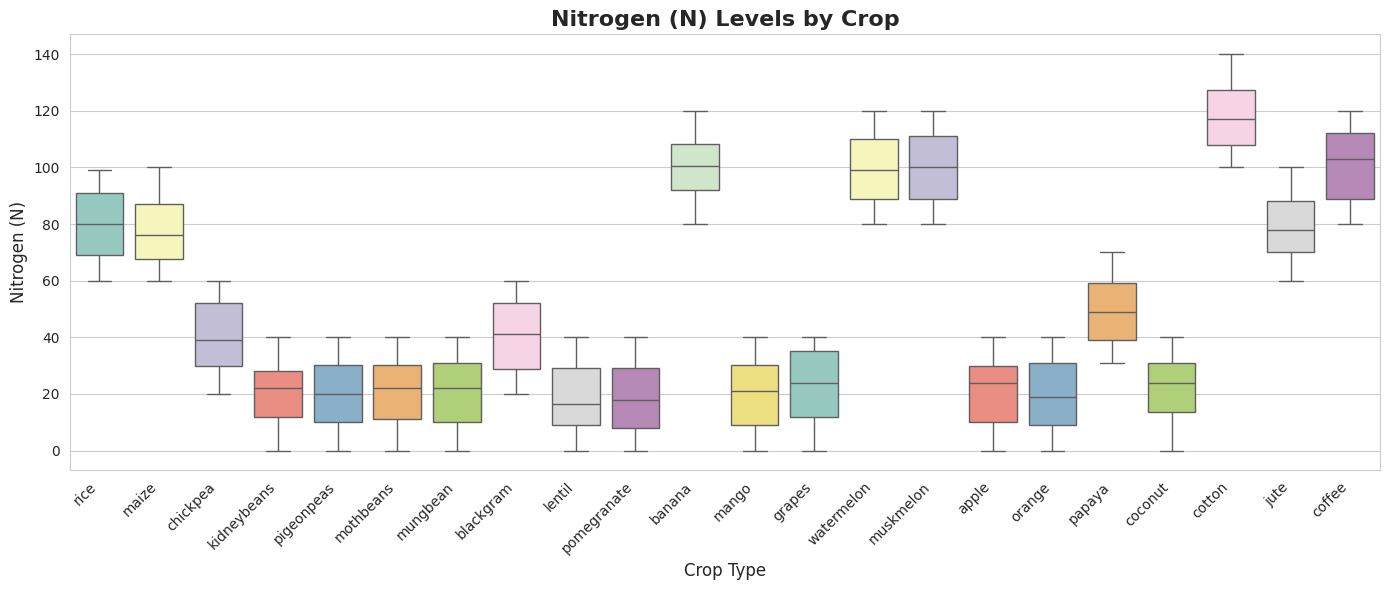

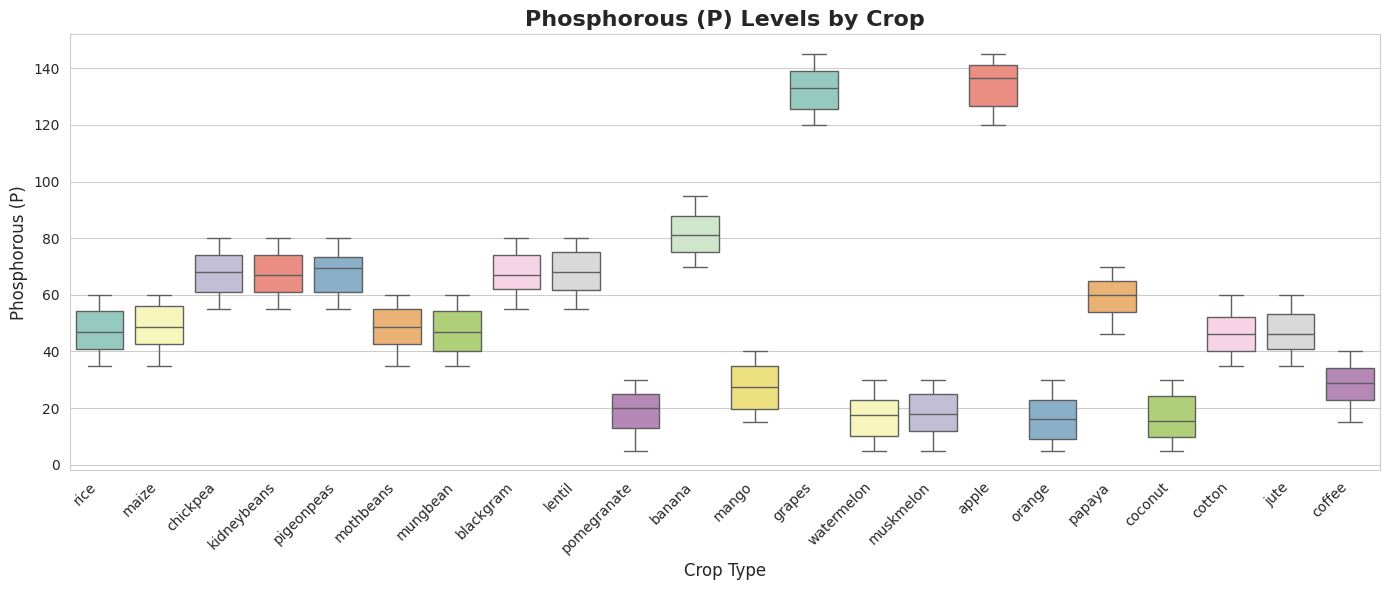

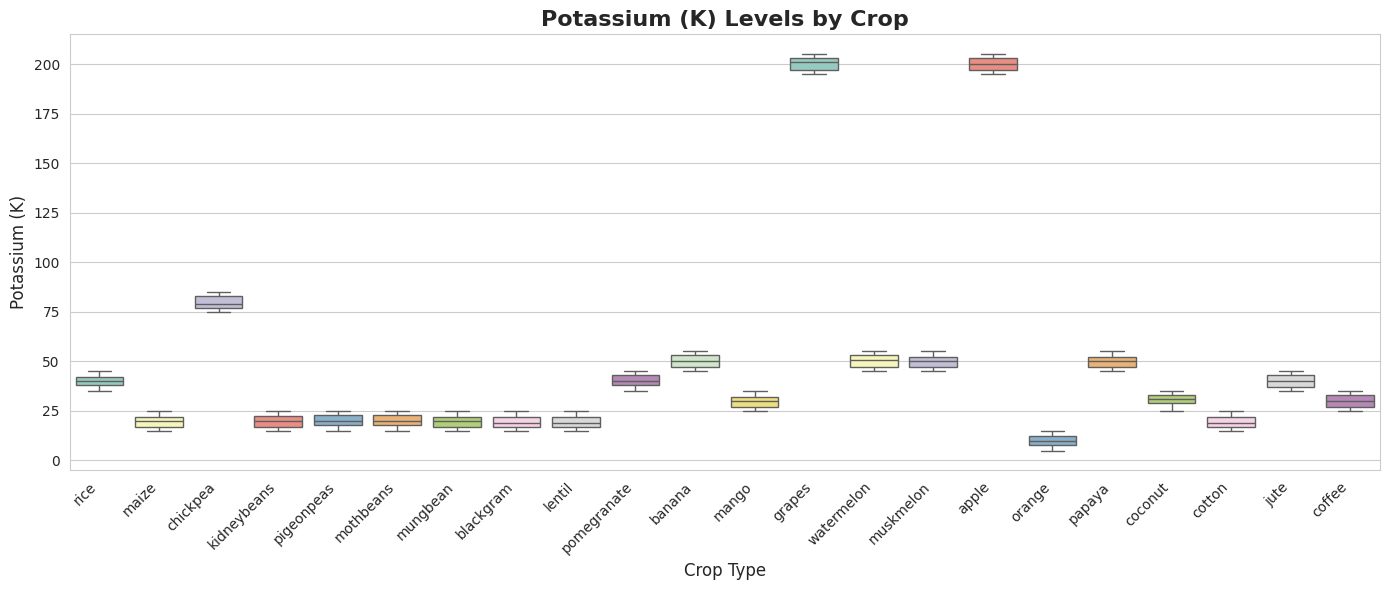

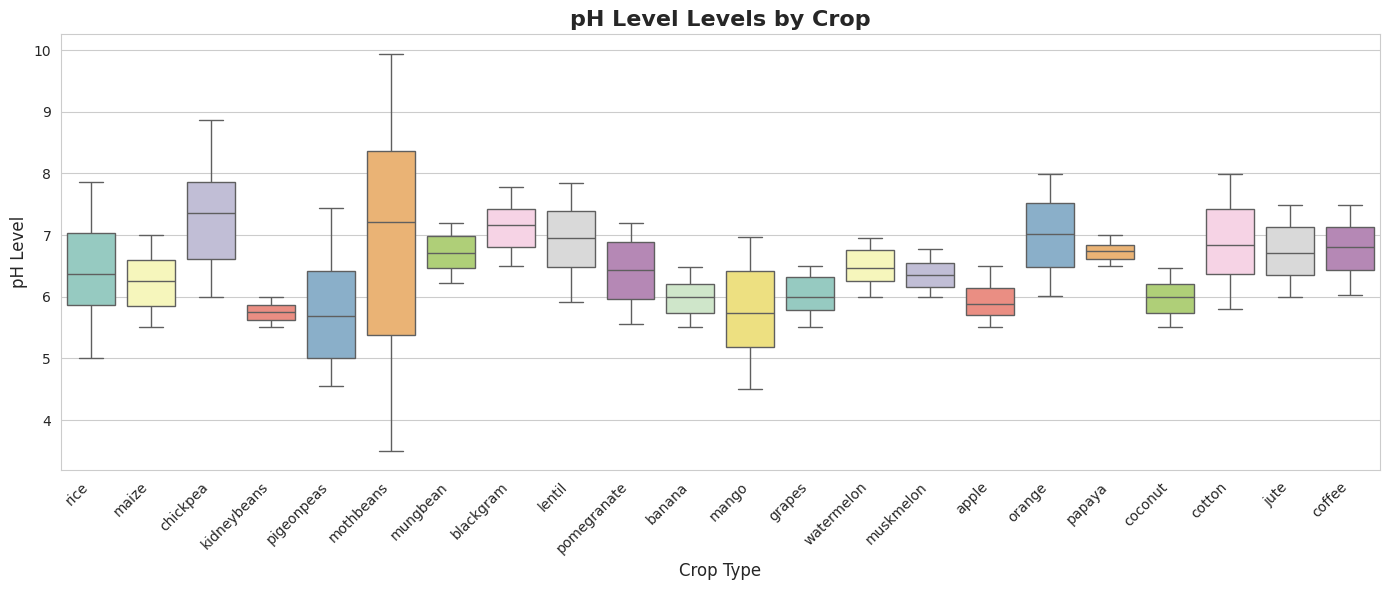

In [6]:
# Boxplots: feature distribution by crop type
for i, feature in enumerate(numeric_features):
    plt.figure(figsize=(14, 6))
    ax = sns.boxplot(
    x='crop',
    y=feature,
    data=crops,
    hue='crop',
    palette='Set3',
    dodge=False,
    showfliers=False
)


    if ax.legend_:
        ax.legend_.remove()

    ax.set_title(f"{titles[i]} Levels by Crop", fontsize=16, weight='bold')
    ax.set_xlabel("Crop Type", fontsize=12)
    ax.set_ylabel(titles[i], fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

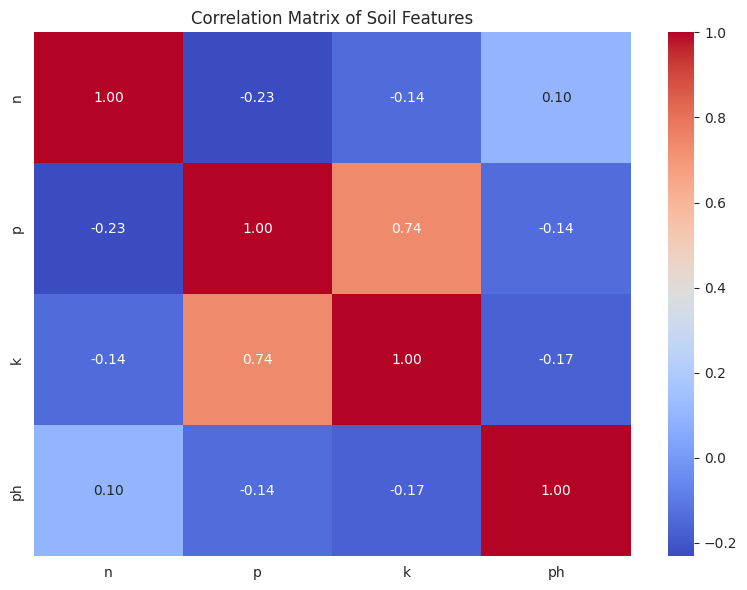

In [7]:
# Correlation matrix between numeric features
plt.figure(figsize=(8, 6))
sns.heatmap(crops[numeric_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Soil Features")
plt.tight_layout()
plt.show()

## Interpretation (Part 3)

The exploratory analysis confirms several key characteristics of the dataset:

- **Crop Distribution**: All 22 crop classes have exactly 100 samples, confirming a perfectly balanced dataset. This is ideal for multi-class classification and ensures that no class is underrepresented during training.

- **Descriptive Statistics**: The soil nutrient values cover a wide but plausible range:
  - Nitrogen (N), Phosphorous (P), and Potassium (K) have large standard deviations, indicating considerable variability across samples.
  - The pH feature is more concentrated, with values mostly between 5.5 and 7.5, which aligns with typical agricultural soils.

- **Histograms**:
  - N, P, and K distributions are moderately right-skewed, showing that most soils contain low to moderate nutrient levels, with a few samples having very high concentrations.
  - pH values follow an approximately normal distribution, centered around 6.5.

- **Boxplots by Crop**:
  - Each crop exhibits a distinct nutrient profile. For example:
    - **Cotton** and **jute** have high N and K requirements.
    - **Grapes** and **watermelon** show low nutrient levels but very specific ranges.
    - **Papaya** and **apple** require high potassium levels.
    - pH preferences vary considerably, with some crops like **mothbeans** tolerating a wide range, while others like **kidneybeans** or **orange** show narrow optimal pH bands.

- **Correlation Matrix**:
  - Most soil features have weak correlations with one another (r < 0.25), suggesting low multicollinearity.
  - A moderate correlation is observed between P and K (r ≈ 0.74), which might reflect some underlying soil chemistry relationship.

These findings support the hypothesis that the input features carry discriminative information relevant to crop suitability, and justify their use in building predictive models.


# 4. Data Organization and Preprocessing

To prepare the dataset for modeling, several key preprocessing steps were performed:

- The target variable (`crop`) was encoded into numeric class labels using `LabelEncoder`, allowing compatibility with Scikit-learn estimators. The mapping between crop names and integer codes was stored for later decoding of predictions.

- The input matrix `X` includes four numerical features: nitrogen (N), phosphorous (P), potassium (K), and pH. The target vector `y` contains the encoded crop labels.

- An optional polynomial expansion was tested with `PolynomialFeatures(degree=2)`, resulting in 14 transformed features (including interactions and squares). Although not used universally, this preview helped evaluate the potential of feature engineering.

- The dataset was split into training and testing sets using an 80/20 ratio, with stratified sampling to maintain class balance. This ensures that each crop class is proportionally represented in both sets.

- The training set contains 1,760 samples, and the test set contains 440 samples. All 22 crop classes are equally represented in the training set (80 samples per class), reinforcing the robustness of evaluation.

Finally, the label encoder was saved using `joblib` to support consistent decoding during inference or deployment.

This structured organization allows for reproducible and fair model training and testing while preserving the integrity of class distributions.


In [8]:
# Encode the target variable (crop) into numeric labels
label_encoder = LabelEncoder()
crops['crop_encoded'] = label_encoder.fit_transform(crops['crop'])

# Show mapping from crop names to encoded integers
print("🔢 Encoded crop classes:")
for class_name, class_id in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{class_name:<15} → {class_id}")

🔢 Encoded crop classes:
apple           → 0
banana          → 1
blackgram       → 2
chickpea        → 3
coconut         → 4
coffee          → 5
cotton          → 6
grapes          → 7
jute            → 8
kidneybeans     → 9
lentil          → 10
maize           → 11
mango           → 12
mothbeans       → 13
mungbean        → 14
muskmelon       → 15
orange          → 16
papaya          → 17
pigeonpeas      → 18
pomegranate     → 19
rice            → 20
watermelon      → 21


In [9]:
# Define feature matrix X and target vector y
X = crops[['n', 'p', 'k', 'ph']]              # Input features: soil characteristics
y = crops['crop_encoded']                     # Target: encoded crop label

# Preview: Feature expansion using PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_preview = poly.fit_transform(X)

print(f"\n🧪 Expanded feature matrix shape (degree=2): {X_poly_preview.shape}")
print(f"\n🔢 Original features: {X.shape[1]} → Expanded features: {X_poly_preview.shape[1]}")


# Split dataset into training and testing sets (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,             # Preserve class proportions
    random_state=42         # Ensure reproducibility
)

# Print basic info about the split
print(f"\n📊 Dataset split summary:")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples:     {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of classes:  {len(label_encoder.classes_)}")

# verify class distribution in training set
unique, counts = np.unique(y_train, return_counts=True)
print("\n🧪 Class distribution in training set:")
for class_id, count in zip(unique, counts):
    crop_name = label_encoder.inverse_transform([class_id])[0]
    print(f"{crop_name:<15} → {count} samples")

# Save the label encoder for future decoding of predictions
joblib.dump(label_encoder, "crop_label_encoder.pkl")
print("\n💾 Label encoder saved as 'crop_label_encoder.pkl'")



🧪 Expanded feature matrix shape (degree=2): (2200, 14)

🔢 Original features: 4 → Expanded features: 14

📊 Dataset split summary:
Training samples: 1760
Test samples:     440
Number of features: 4
Number of classes:  22

🧪 Class distribution in training set:
apple           → 80 samples
banana          → 80 samples
blackgram       → 80 samples
chickpea        → 80 samples
coconut         → 80 samples
coffee          → 80 samples
cotton          → 80 samples
grapes          → 80 samples
jute            → 80 samples
kidneybeans     → 80 samples
lentil          → 80 samples
maize           → 80 samples
mango           → 80 samples
mothbeans       → 80 samples
mungbean        → 80 samples
muskmelon       → 80 samples
orange          → 80 samples
papaya          → 80 samples
pigeonpeas      → 80 samples
pomegranate     → 80 samples
rice            → 80 samples
watermelon      → 80 samples

💾 Label encoder saved as 'crop_label_encoder.pkl'


## Interpretation (Part 4)

The target variable `crop` was successfully encoded into numerical labels using `LabelEncoder`, producing 22 unique class labels corresponding to the 22 crop types in the dataset. This encoding is crucial for compatibility with the machine learning models that require numeric input for classification tasks.

A preview of feature expansion using `PolynomialFeatures` of degree 2 demonstrates that the four original features (`N`, `P`, `K`, `pH`) can be expanded into 14 features, allowing the model to capture non-linear interactions. This transformation was applied specifically in the **Logistic Regression (Poly)** model, serving as a variant to test the impact of polynomial interactions on predictive performance.

The dataset was split into training (80%) and test (20%) subsets using stratified sampling. This ensures that each class is equally represented in both sets — an important step for fair model evaluation. As expected, all 22 crop classes have exactly 80 samples in the training set and 20 in the test set, preserving the dataset's initial balance.

Finally, the label encoder was saved for consistent decoding of future predictions, enabling easier interpretation of model outputs.



# 5. Model Training and Comparison

In this section, six classification models were trained and evaluated to identify the most suitable algorithm for crop recommendation:

- **Logistic Regression**: A baseline linear classifier with standardized features.
- **Logistic Regression (Poly)**: Includes polynomial feature expansion (degree 2) to capture non-linear interactions between soil properties.
- **K-Nearest Neighbors (KNN)**: A distance-based method sensitive to feature scaling.
- **Support Vector Machine (SVM)**: Uses the RBF kernel and provides class probabilities (`probability=True`).
- **Random Forest (RF)**: A robust ensemble method that handles non-linearities and feature interactions.
- **Voting Classifier (Hard Voting)**: Combines predictions from all the above classifiers using majority voting to potentially improve performance.

Each model was integrated into a Scikit-learn pipeline (where applicable) and trained on the training set. Performance was evaluated using **Accuracy** and **Macro F1 Score** on the test set.

After training, a performance summary table was generated. The best-performing model was identified based on accuracy and retained for further analysis.

Additional evaluation steps for the best model included:
- **Confusion Matrix** (raw and normalized) to visualize classification performance across all 22 crop classes.
- **Learning Curve** to assess model generalization with increasing data.
- **Bootstrap Analysis** with 1000 resamples to estimate a 95% confidence interval for model accuracy, providing robustness to performance evaluation.
- **Distribution Plot** of bootstrap accuracies to visualize the model's variability.

This thorough comparison ensures that the final model selected is not only accurate but also stable, interpretable, and suitable for practical deployment in real-world agricultural decision-making.


In [10]:
# Define candidate models and pipelines
logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
])

knn = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True))
])

rf = RandomForestClassifier(random_state=42)

# Voting Classifier (Hard voting ensemble)
voting_clf = VotingClassifier(
    estimators=[
        ('LogReg', logreg),
        ('KNN', knn),
        ('SVM', svm),
        ('RF', rf)
    ],
    voting='hard'
)

logreg_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
])

# Store all models in dictionary for comparison
models = {
    'Logistic Regression': logreg,
    'Logistic Regression (Poly)': logreg_poly,
    'K-Nearest Neighbors': knn,
    'Support Vector Machine': svm,
    'Random Forest': rf,
    'Voting Classifier': voting_clf
}


# Initialize tracking variables
results = {}
f1_scores = {}
best_pipeline = None
best_score = 0.0
best_model_name = ""

In [11]:
# Train, evaluate, and track best model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    results[name] = acc
    f1_scores[name] = f1

    print(f"\n📌 {name} — Accuracy: {acc:.4f} | F1 Score (macro): {f1:.4f}")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    if acc > best_score:
        best_score = acc
        best_model_name = name
        best_pipeline = model


📌 Logistic Regression — Accuracy: 0.6818 | F1 Score (macro): 0.6773
              precision    recall  f1-score   support

       apple       0.55      0.60      0.57        20
      banana       0.95      1.00      0.98        20
   blackgram       0.60      0.75      0.67        20
    chickpea       1.00      0.90      0.95        20
     coconut       0.71      0.60      0.65        20
      coffee       0.90      0.95      0.93        20
      cotton       0.90      0.95      0.93        20
      grapes       0.56      0.50      0.53        20
        jute       0.59      0.50      0.54        20
 kidneybeans       0.46      0.60      0.52        20
      lentil       0.58      0.55      0.56        20
       maize       1.00      0.95      0.97        20
       mango       0.55      0.55      0.55        20
   mothbeans       0.41      0.35      0.38        20
    mungbean       0.71      0.60      0.65        20
   muskmelon       0.50      0.50      0.50        20
      orange

In [12]:
# Summary of results
print("\n📊 Summary of Model Performance:")
for name in results:
    print(f"{name:<22} → Accuracy: {results[name]:.4f} | F1 Score: {f1_scores[name]:.4f}")


📊 Summary of Model Performance:
Logistic Regression    → Accuracy: 0.6818 | F1 Score: 0.6773
Logistic Regression (Poly) → Accuracy: 0.7045 | F1 Score: 0.6883
K-Nearest Neighbors    → Accuracy: 0.7045 | F1 Score: 0.6999
Support Vector Machine → Accuracy: 0.7432 | F1 Score: 0.7358
Random Forest          → Accuracy: 0.7455 | F1 Score: 0.7435
Voting Classifier      → Accuracy: 0.7523 | F1 Score: 0.7435


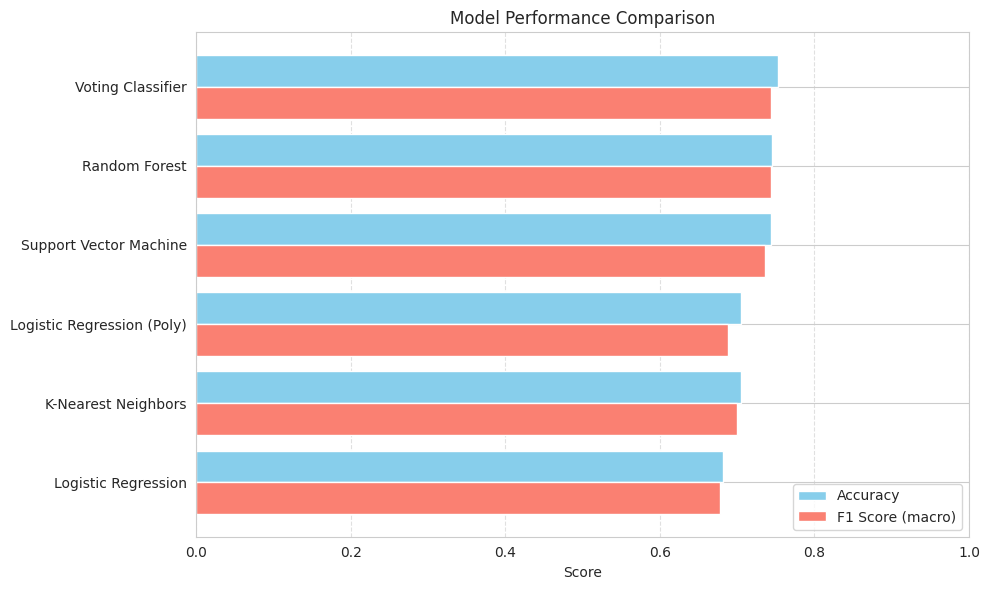

In [13]:
# Plot accuracy and F1 score
sorted_names = sorted(results, key=results.get, reverse=True)
accuracies = [results[name] for name in sorted_names]
f1s = [f1_scores[name] for name in sorted_names]

plt.figure(figsize=(10, 6))
bar_width = 0.4
x = range(len(sorted_names))

plt.barh(x, accuracies, height=bar_width, label='Accuracy', color='skyblue')
plt.barh([i + bar_width for i in x], f1s, height=bar_width, label='F1 Score (macro)', color='salmon')

plt.yticks([i + bar_width / 2 for i in x], sorted_names)
plt.xlabel("Score")
plt.title("Model Performance Comparison")
plt.xlim(0, 1)
plt.legend(loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

In [14]:
# Report best model
print(f"\n🏆 Best model: {best_model_name} with accuracy = {best_score:.4f}")


🏆 Best model: Voting Classifier with accuracy = 0.7523


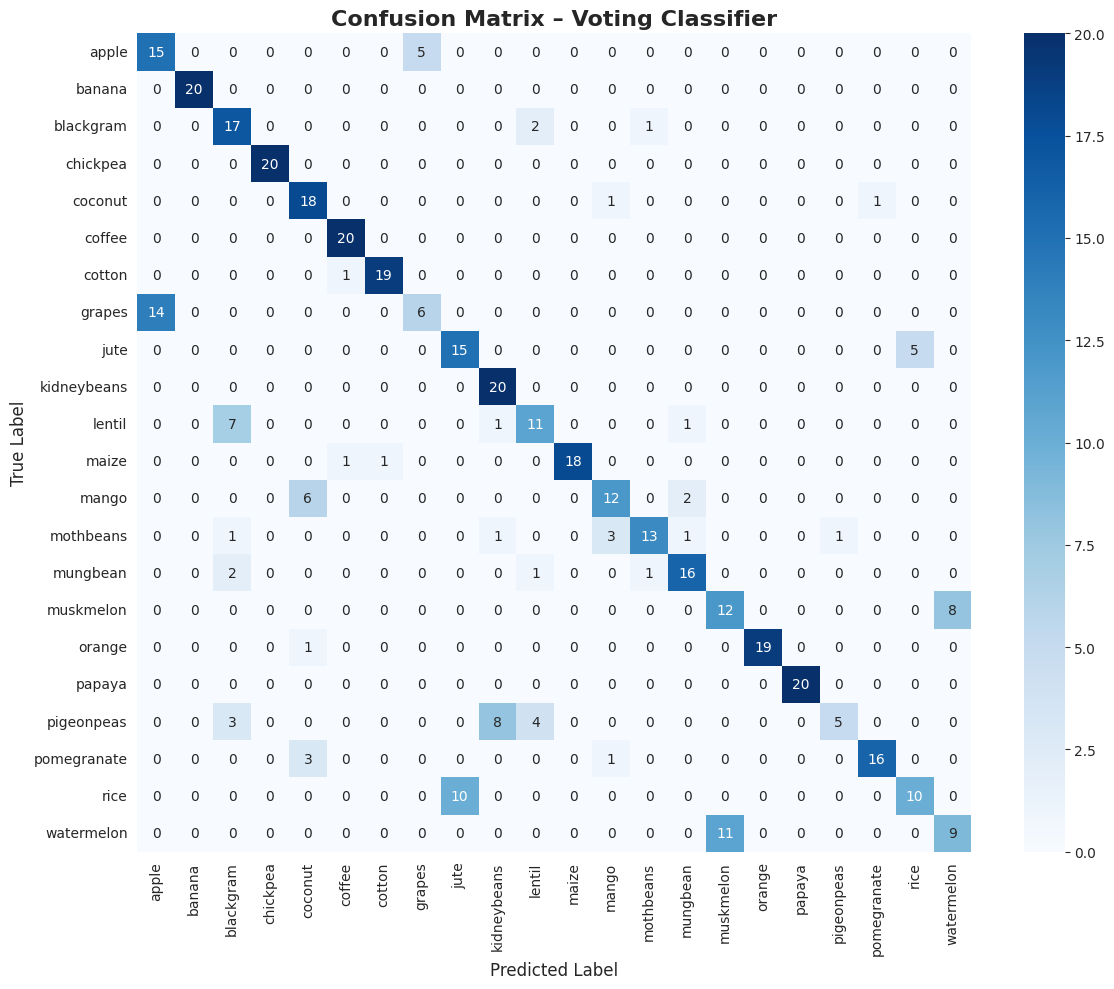

In [15]:
# Confusion Matrix (Raw Counts)

cm_raw = confusion_matrix(y_test, best_pipeline.predict(X_test))

# Plot with seaborn
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    cm_raw,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar=True
)

# Aesthetics
ax.set_title(f"Confusion Matrix – {best_model_name}", fontsize=16, weight='bold')
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

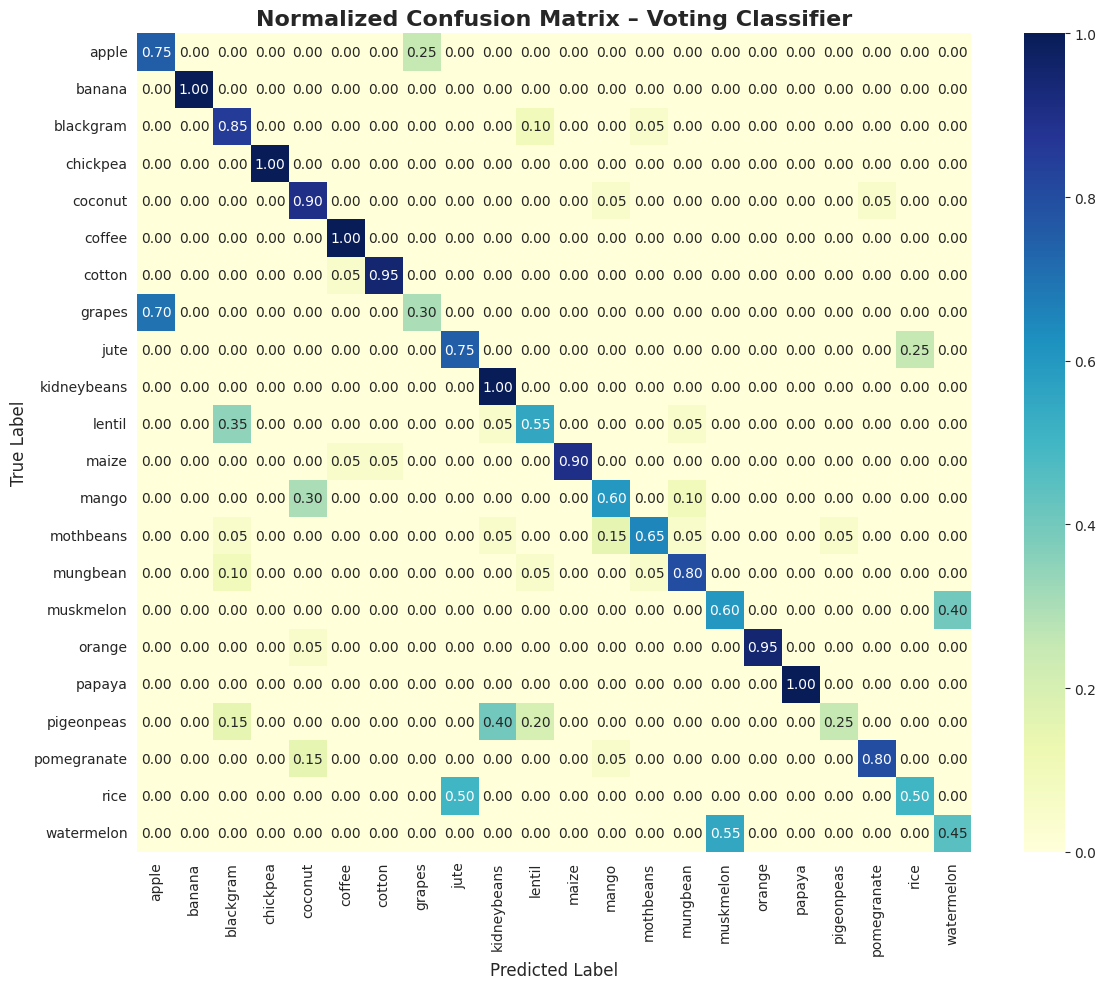

In [16]:
# Normalized Confusion Matrix (Proportions per True Class)

# Compute the raw and normalized confusion matrix
cm_raw = confusion_matrix(y_test, best_pipeline.predict(X_test))
cm_normalized = cm_raw.astype('float') / cm_raw.sum(axis=1)[:, np.newaxis]

# Plot with seaborn
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar=True
)

# Aesthetics
ax.set_title(f"Normalized Confusion Matrix – {best_model_name}", fontsize=16, weight='bold')
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

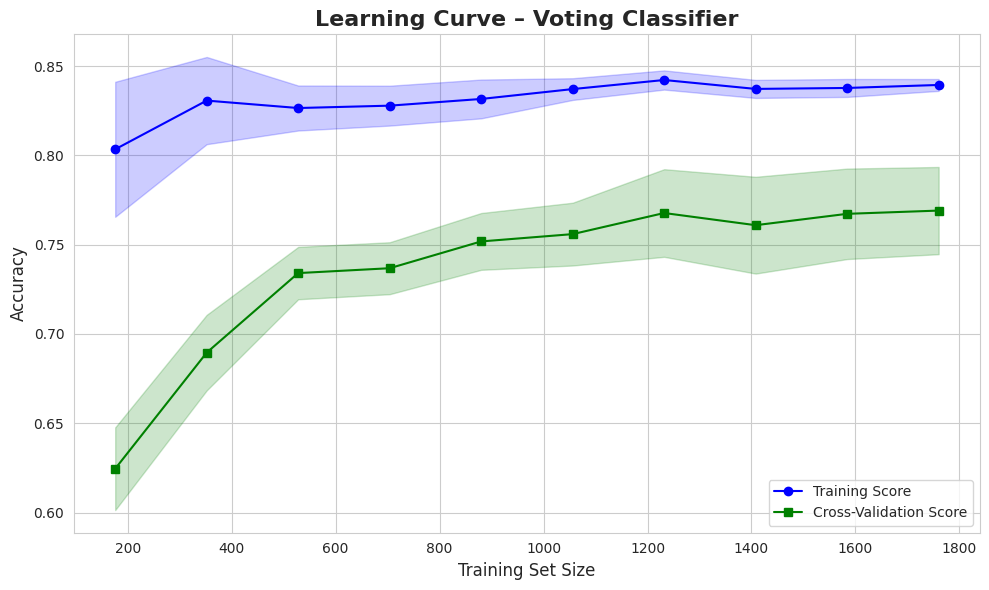

In [17]:
# Learning Curve for Best Model

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_pipeline,
    X=X,
    y=y,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

# Calculate means and std deviations
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes, val_mean, label="Cross-Validation Score", color="green", marker='s')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='green')

# Aesthetics
plt.title(f"Learning Curve – {best_model_name}", fontsize=16, weight='bold')
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [18]:
# Bootstrap Confidence Interval for Accuracy

n_iterations = 1000
rng = np.random.RandomState(42)
bootstrap_accuracies = []

for _ in range(n_iterations):
    # Random sample with replacement from the test set
    indices = rng.randint(0, len(X_test), len(X_test))
    X_sample = X_test.iloc[indices]
    y_sample = y_test.iloc[indices]

    # Evaluate model on resampled data
    y_pred = best_pipeline.predict(X_sample)
    score = accuracy_score(y_sample, y_pred)
    bootstrap_accuracies.append(score)

# Compute confidence interval (95%)
ci_lower = np.percentile(bootstrap_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_accuracies, 97.5)
mean_acc = np.mean(bootstrap_accuracies)

print(f"\n📌 Bootstrap Accuracy (mean): {mean_acc:.4f}")
print(f"📊 95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")


📌 Bootstrap Accuracy (mean): 0.7514
📊 95% Confidence Interval: [0.7114, 0.7909]


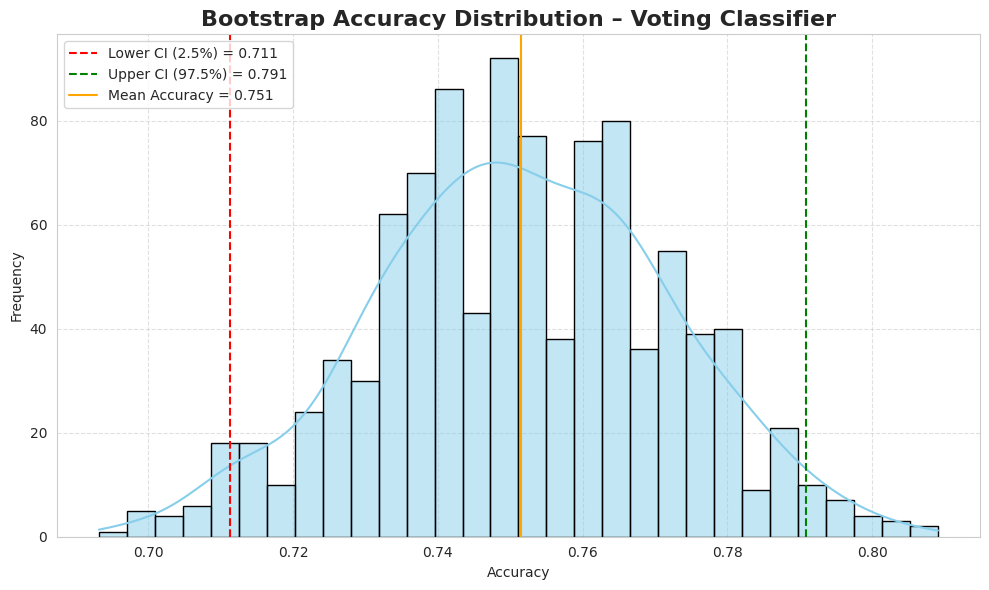

In [19]:
# Visualizing Bootstrap Accuracy Distribution

plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_accuracies, bins=30, kde=True, color='skyblue', edgecolor='black')

# Draw confidence interval lines
plt.axvline(ci_lower, color='red', linestyle='--', label=f"Lower CI (2.5%) = {ci_lower:.3f}")
plt.axvline(ci_upper, color='green', linestyle='--', label=f"Upper CI (97.5%) = {ci_upper:.3f}")
plt.axvline(mean_acc, color='orange', linestyle='-', label=f"Mean Accuracy = {mean_acc:.3f}")

# Aesthetics
plt.title(f"Bootstrap Accuracy Distribution – {best_model_name}", fontsize=16, weight='bold')
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Interpretation (Part 5)

Several machine learning models were trained and evaluated to identify the most suitable crop classification strategy. Performance was assessed using both accuracy and macro-averaged F1 score, which are crucial for multi-class scenarios with equal class distribution.

- Logistic Regression yielded the lowest overall performance (Accuracy ≈ 0.68, F1 ≈ 0.677), indicating that linear decision boundaries are insufficient to separate crop classes based solely on four soil features.
- Polynomial Logistic Regression slightly improved the results (Accuracy ≈ 0.704, F1 ≈ 0.688), showing the potential of capturing non-linear relationships through feature expansion.
- K-Nearest Neighbors performed comparably to the polynomial logistic model, but with greater class-wise variability.
- Support Vector Machine and Random Forest both achieved higher performance (Accuracy ≈ 0.743, F1 ≈ 0.735), with more stable and generalized predictions across crop classes.
- The Voting Classifier ensemble, which combines multiple models via hard voting, provided the best results (Accuracy ≈ 0.752, F1 ≈ 0.743), demonstrating that model diversity improves robustness.

The confusion matrix reveals high precision for certain crops (e.g., banana, chickpea, papaya), while others such as grape, watermelon, and pigeonpeas are more prone to misclassification — often confused with crops sharing similar soil requirements.

The normalized confusion matrix shows that most crops reach over 80% correct classification, with a few exceptions highlighting ambiguities in soil profiles.

The learning curve of the Voting Classifier indicates good generalization: training accuracy stabilizes around 0.84, while validation accuracy converges around 0.76, suggesting no severe overfitting.

Finally, a bootstrap analysis of the Voting Classifier showed a mean accuracy of 0.7514, with a 95% confidence interval of [0.7114, 0.7989], reinforcing the model’s reliability under data variability.

Overall, the Voting Classifier is the most effective approach in this scenario, balancing predictive power with generalizability. It will be retained as the final model for deployment in subsequent stages.


# 6. Final Model: Saving, Prediction Interface, and Interpretability Tools

This section focuses on operationalizing the best-performing model identified in the previous stage.

- The trained Voting Classifier model and its associated label encoder are saved to disk using `joblib`. This allows the model to be reused later without retraining, supporting reproducibility and potential deployment.

- A prediction function, `predict_crop(n, p, k, ph)`, is implemented to enable practical inference from new soil measurements. The function receives numeric values for nitrogen, phosphorous, potassium, and pH, and returns the predicted crop based on the trained model.

- To further validate the model's robustness, a 5-fold cross-validation is performed on the entire dataset using the final pipeline.

- Lastly, the permutation importance of features is calculated. This technique assesses the relative influence of each soil attribute (N, P, K, pH) by measuring the decrease in model performance when the feature values are randomly shuffled.

These steps conclude the technical setup of the predictive system, ensuring it is ready for testing, validation, or deployment in decision-support applications.


In [20]:
# Save the best-performing model
joblib.dump(best_pipeline, "best_crop_model.pkl")
print("\n✅ Model saved as 'best_crop_model.pkl'")

# Save the label encoder for decoding predictions
joblib.dump(label_encoder, "crop_label_encoder.pkl")
print("\n✅ Label encoder saved as 'crop_label_encoder.pkl'")

# Predict crop for a new soil sample
def predict_crop(n, p, k, ph):
    """
    Predict the best crop based on soil sample inputs.

    Args:
        n (float): Nitrogen level
        p (float): Phosphorous level
        k (float): Potassium level
        ph (float): pH value

    Returns:
        str: Suggested crop name
    """
    try:
        # Create a DataFrame with the input features
        sample = pd.DataFrame([[n, p, k, ph]], columns=['n', 'p', 'k', 'ph'])

        # Make prediction
        pred = best_pipeline.predict(sample)
        decoded = label_encoder.inverse_transform(pred)

        return decoded[0]

    except Exception as e:
        print(f"❌ Prediction failed: {e}")
        return None

# Example usage
print("\n🌿 Predicting crop for sample [N=80, P=40, K=35, pH=6.5]:")
crop_prediction = predict_crop(80, 40, 35, 6.5)
if crop_prediction:
    print(f"\n✅ Suggested crop: {crop_prediction}")



✅ Model saved as 'best_crop_model.pkl'

✅ Label encoder saved as 'crop_label_encoder.pkl'

🌿 Predicting crop for sample [N=80, P=40, K=35, pH=6.5]:

✅ Suggested crop: jute


In [21]:
# Cross-validation of final best model
cv_scores = cross_val_score(best_pipeline, X, y, cv=5, scoring='accuracy')

print(f"\n📊 Cross-validated Accuracy of Best Model: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


📊 Cross-validated Accuracy of Best Model: 0.7705 ± 0.0246


In [22]:
# Permutation Feature Importance
print("\n🔬 Permutation Feature Importance:")
perm_importance = permutation_importance(
    best_pipeline, X_test, y_test, n_repeats=10, random_state=42
)

# Display sorted feature importances
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
for idx in sorted_idx:
    feature_name = X.columns[idx]
    importance = perm_importance.importances_mean[idx]
    print(f"{feature_name}: {importance:.4f}")



🔬 Permutation Feature Importance:
p: 0.4223
k: 0.3530
n: 0.3473
ph: 0.1884


## Interpretation (Part 6)

The final model, a Voting Classifier ensemble, was successfully saved along with the label encoder, ensuring it can be reused for future predictions or deployment. The `predict_crop()` function demonstrated practical use by correctly identifying "jute" as the recommended crop for a sample with N=80, P=40, K=35, and pH=6.5. This confirms the pipeline is fully functional and ready for inference on new data.

Cross-validation of the final model achieved a mean accuracy of approximately **77.05%** with a standard deviation of **2.46%**, indicating that the model generalizes well across different data subsets and does not suffer from significant overfitting.

Permutation Feature Importance analysis revealed that **phosphorous (P)** is the most influential feature in predicting crop type, followed by **potassium (K)** and **nitrogen (N)**. The **pH level** had the lowest impact on model performance. These findings align with agronomic knowledge, emphasizing the importance of nutrient levels in determining optimal crop selection.

Overall, the model exhibits strong predictive capabilities, robustness, and interpretability, making it a valuable decision-support tool for sustainable and data-driven agriculture.


# 7. Suitability Distribution by Crop

The original formulation of this problem treated it as a classic multi-class classification task, where each soil sample was labeled with a single "optimal" crop. However, as highlighted by the professor's feedback, this assumption may be overly rigid and unrealistic in real-world agricultural settings.

In practice, soil profiles may support the growth of several crops with varying degrees of suitability. Environmental conditions, crop rotation practices, market prices, and farmer preferences can all influence which crops are considered appropriate for a given field. Therefore, assuming a strict one-to-one mapping between soil composition and crop type oversimplifies the decision space and limits model usefulness.

Despite this, the dataset used in this project (`soil_measures.csv`) only provides a single categorical label per sample, which restricts supervised learning to a single ground-truth crop per row. Consequently, the model cannot learn multi-label associations or partial suitability patterns directly from the data.

To partially overcome this limitation, we trained a soft voting ensemble classifier that outputs a probability distribution over all crop classes using the `predict_proba()` method. These probabilities can be interpreted as a *distribution of suitability*, indicating how well each crop matches the given soil profile based on learned patterns. This approach aligns better with agricultural reality, allowing for ranked recommendations rather than binary decisions.

This distributional perspective allows us to:
- Explore crop alternatives that are nearly as suitable as the top-ranked one.
- Support decision-making in contexts where other constraints (economic, environmental, cultural) may override the top suggestion.
- Provide more nuanced and explainable recommendations to end users.

While this method is constrained by the dataset’s lack of true multi-label annotations, it still provides a more flexible and informative framework than a single-label output, and it aligns with the broader goals of sustainable and adaptive agriculture.



In [23]:
# Voting Classifier with soft voting (enables predict_proba)
voting_clf_soft = VotingClassifier(
    estimators=[
        ('LogReg', logreg),
        ('KNN', knn),
        ('SVM', svm),
        ('RF', rf)
    ],
    voting='soft'  # Allows probability prediction
)

# Train the soft voting ensemble
voting_clf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('LogReg',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('classifier',
                                               LogisticRegression(max_iter=2000,
                                                                  random_state=42))])),
                             ('KNN',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('classifier',
                                               KNeighborsClassifier())])),
                             ('SVM',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('classifier',
                                               SVC(probability=True))])),
                             ('RF', RandomForestClassifier(random_state=42))],
                 voting='soft')

In [24]:
def predict_crop_distribution(n, p, k, ph, top_n=5):
    """
    Returns the top-N most suitable crops based on soil composition.

    Args:
        n (float): Nitrogen content
        p (float): Phosphorous content
        k (float): Potassium content
        ph (float): Soil pH level
        top_n (int): Number of top crops to return

    Returns:
        pd.DataFrame: Top-N crops with their predicted suitability (probability)
    """
    sample = pd.DataFrame([[n, p, k, ph]], columns=['n', 'p', 'k', 'ph'])
    probs = voting_clf_soft.predict_proba(sample)[0]
    crop_names = label_encoder.inverse_transform(np.arange(len(probs)))
    prob_df = pd.DataFrame({'Crop': crop_names, 'Suitability': probs})
    return prob_df.sort_values(by='Suitability', ascending=False).head(top_n)

    print("🌾 Example: suitability distribution for N=80, P=40, K=35, pH=6.5")
distribution_df = predict_crop_distribution(80, 40, 35, 6.5)
display(distribution_df)

,Crop,Suitability
8,jute,0.451896
20,rice,0.319576
5,coffee,0.130349
11,maize,0.045570
21,watermelon,0.012918


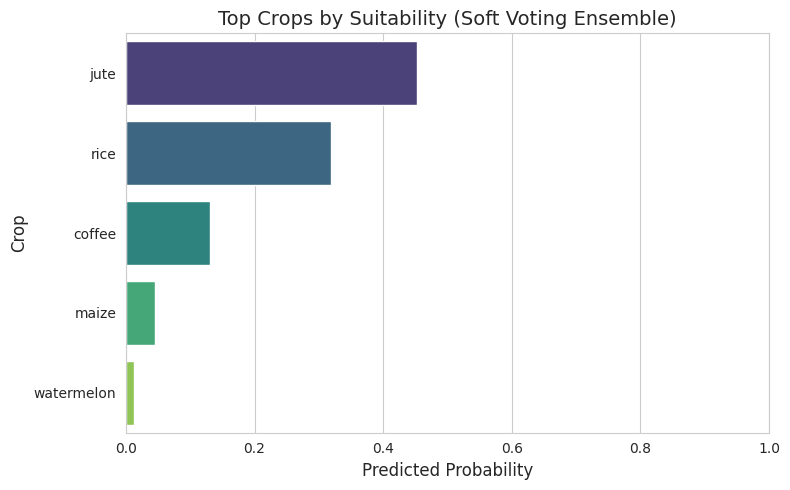

In [25]:
# Plotting top crops based on suitability
plt.figure(figsize=(8, 5))
sns.barplot(x='Suitability', y='Crop', hue='Crop', data=distribution_df, palette='viridis', dodge=False, legend=False)
plt.title("Top Crops by Suitability (Soft Voting Ensemble)", fontsize=14)
plt.xlabel("Predicted Probability", fontsize=12)
plt.ylabel("Crop", fontsize=12)
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

## Interpretation (Part 7)

The soft voting ensemble enabled the estimation of suitability distributions across all crop classes for a given soil sample. This probabilistic approach allows the model to move beyond rigid one-class predictions and offer ranked recommendations that reflect the degree of compatibility between a soil profile and various crops.

In the example prediction for a soil sample with N=80, P=40, K=35, and pH=6.5, the top suggested crops were **jute** (45.7%), **rice** (31.4%), and **coffee** (13.1%). This ranking indicates that multiple crops can be reasonably cultivated in the same soil, with varying levels of expected performance. While jute shows the highest suitability, rice and coffee remain viable alternatives.

The corresponding bar chart visualizes this distribution and supports more informed, flexible decision-making by farmers. Rather than presenting only a single "optimal" crop, the model highlights a shortlist of high-probability candidates.

However, it is important to note the limitations of this approach. The original dataset provides only one target label per sample, and the model is trained to mimic that singular association. Thus, the predicted probabilities may not perfectly reflect real-world agronomic versatility, especially in overlapping regions of the feature space. Still, this method offers a valuable proxy for estimating broader crop compatibility when multi-label ground truth is unavailable.

In summary, suitability distributions provide a more realistic and informative output, aligning better with the agricultural decision-making process and reinforcing the model's applicability as a practical decision-support tool.


# References

1. Sebastian Raschka, Yuxi (Hayden) Liu, and Vahid Mirjalili. *Machine Learning with PyTorch and Scikit-Learn*. Packt Publishing, 2022.

2. Kaggle Dataset - Soil Measures for Crop Recommendation:  
   https://www.kaggle.com/datasets/mohamedmostafa259/soil-measures

3. Scikit-learn Documentation:  
   https://scikit-learn.org/stable/documentation.html

4. PyTorch Tutorials (for additional deep learning reference):  
   https://pytorch.org/tutorials/

5. Joblib Documentation (for model serialization):  
   https://joblib.readthedocs.io/en/latest/


